In [15]:
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR" #pr39

In [16]:
amino_acids = {'VAL':'V', 'ILE':'I', 'LEU':'L', 'GLU':'E', 'GLN':'Q', \
'ASP':'D', 'ASN':'N', 'HIS':'H', 'TRP':'W', 'PHE':'F', 'TYR':'Y',    \
'ARG':'R', 'LYS':'K', 'SER':'S', 'THR':'T', 'MET':'M', 'ALA':'A',    \
'GLY':'G', 'PRO':'P', 'CYS':'C'}

In [17]:
class enzyme():
    """
    Enzyme with p1 specificity
    """
    def __init__(self, specificity:dict):
        self.specificity = specificity
        assert sum(specificity.values()) - 1 < 0.001
        self.aas = list(specificity.keys())

protease_iv = enzyme({"K":1})
trypsin = enzyme({"K":0.5, "R":0.5})
elne = enzyme({"V":0.5, "I":0.25, "A":0.15, "T":0.1})
unspecific = enzyme({v: 1/len(amino_acids.values()) for k, v in amino_acids.items()})

In [18]:
def find_aa(protein_sequence, target):
    indices = []
    for i, amino_acid in enumerate(protein_sequence):
        if amino_acid == target:
            indices.append(i)
    return indices

find_aa(hbb,  "K")

[8, 17, 59, 60, 64, 65, 81, 94, 119, 131, 143]

In [20]:
import numpy as np
import networkx as nx

def get_probability_for_cut(G, enzyme):
    # Probability should be n_cut_sites*copy_number
    total_prob = 0
    prob_sequences = []
    for node in G.nodes(data=True):
        seq = node[0]
        cut_sites = 0
        copy_nr = node[1]["copy_number"]
        for aa in enzyme.aas:
            cut_sites += len(find_aa(seq, aa))
        prob_sequence = copy_nr*cut_sites
        prob_sequences.append(prob_sequence)
        total_prob += prob_sequence
    return [x/total_prob for x in prob_sequences]


def cleave(sequences, enzyme=None, n_cleaves=10):
    G = nx.Graph()
    G.add_node(sequences, copy_number=n_cleaves)
    if isinstance(sequences,str):
        sequences = [sequences]

    for _ in range(n_cleaves):
        sequence = np.random.choice(sequences, p=get_probability_for_cut(G, enzyme))
        G.nodes()[sequence]["copy_number"] = G.nodes()[sequence]["copy_number"] - 1

        indices = []
        probabilities = []
        if enzyme:
            for aa in enzyme.aas:
                new_indices= find_aa(sequence, aa)
                indices += new_indices
                probabilities += [enzyme.specificity[aa]]*len(new_indices)
        total_probabilities = sum(probabilities)
        probabilities = [p/total_probabilities for p in probabilities]

        # cleave at random aa in sequence
        index = np.random.choice(indices, p=probabilities)

        left = sequence[:index+1]
        if left in G.nodes():
            G.nodes()[left]["copy_number"] = G.nodes()[left]["copy_number"] + 1

        right = sequence[index+1:]

        if right in G.nodes():
            G.nodes()[right]["copy_number"] = G.nodes()[right]["copy_number"] + 1
            
        if len(right) > 6:
            if right not in sequences:
                sequences.append(right)
                G.add_node(right, copy_number=1)
                G.add_edge(sequence, right)
                
        if len(left) > 6:
            if left not in sequences:
                sequences.append(left)
                G.add_node(left, copy_number=1)
                G.add_edge(sequence, left)
    return G


G = cleave(hbb, enzyme=trypsin, n_cleaves=100)


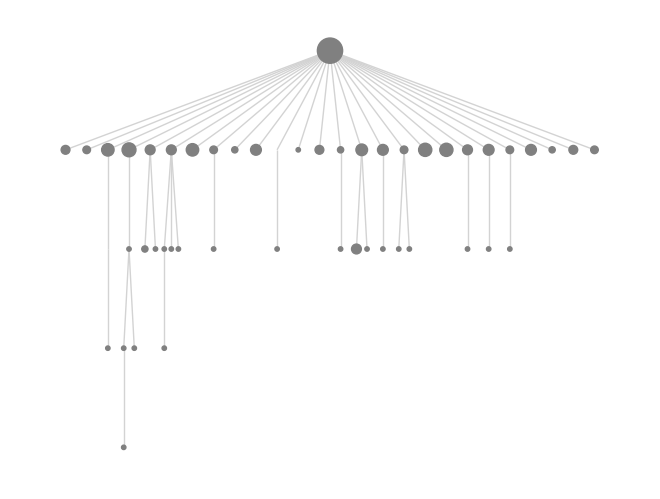

In [21]:
from hierarchy_pos import hierarchy_pos
import matplotlib.pyplot as plt


pos = hierarchy_pos(G, hbb) 
node_size = [n[1]["copy_number"]*10 for n in G.nodes(data=True)]
nx.draw(G, pos = pos, node_size=node_size, node_color="gray", edge_color="lightgray")
plt.savefig("../plots/tree_KR_specificity_n100.svg")

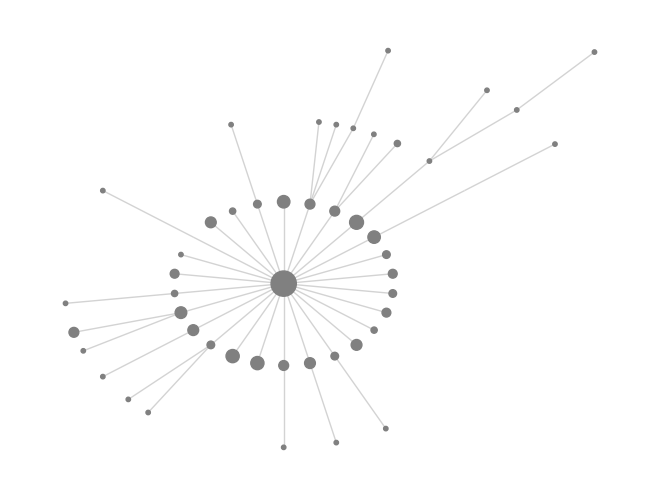

In [22]:
import math
pos = hierarchy_pos(G, hbb, width = 2*math.pi, xcenter=0)
new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
nx.draw(G, pos = new_pos, node_size=node_size, node_color="gray", edge_color="lightgray")

In [23]:
def get_disassembly_index_for_node(G, node, grandparent):
    # mean length = max_length * 2 / max_length - 1
    if node == grandparent:
        return 0
    max_len = len(max(nx.all_simple_paths(G, node, grandparent), key=lambda x: len(x)))
    return (2*max_len / max_len - 1)

def get_disassembly(G, grandparent):
    disassembly = 0 
    n_t = sum([node[1]["copy_number"] for node in G.nodes(data=True)])

    for node in G.nodes(data=True):
        n_i_minus_one = node[1]["copy_number"]-1
        if n_i_minus_one > 0:
            disassembly += (math.e**get_disassembly_index_for_node(G, node[0], grandparent))*(n_i_minus_one/n_t)
    return disassembly


get_disassembly(G, hbb)

1.7103332073898954

In [24]:
e = get_disassembly(cleave(hbb, enzyme=elne, n_cleaves=500), hbb)
t = get_disassembly(cleave(hbb, enzyme=trypsin, n_cleaves=500), hbb)
p = get_disassembly(cleave(hbb, enzyme=protease_iv, n_cleaves=500), hbb)
u = get_disassembly(cleave(hbb, enzyme=unspecific, n_cleaves=500), hbb)

print(e,t,p,u)

1.7490570727113124 2.100187135734916 2.1848251347461285 1.1671683408636802


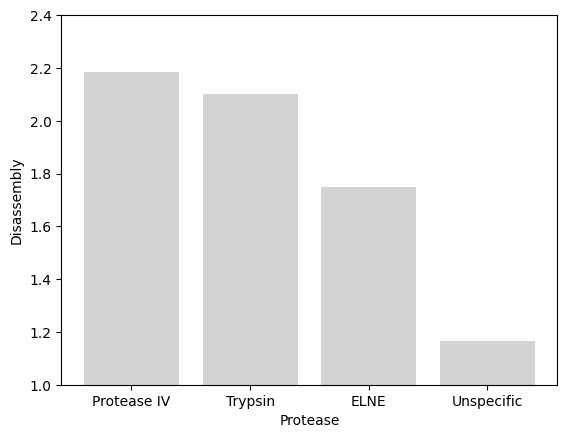

In [26]:
plt.bar(x=[0,1,2,3], height=[p,t,e,u], color="lightgray")
plt.ylim([1,2.4])
plt.ylabel("Disassembly")
plt.xlabel("Protease")
plt.xticks([0,1,2,3], ["Protease IV", "Trypsin", "ELNE", "Unspecific"])
plt.savefig("../plots/bar_disassembly_specificity.svg")

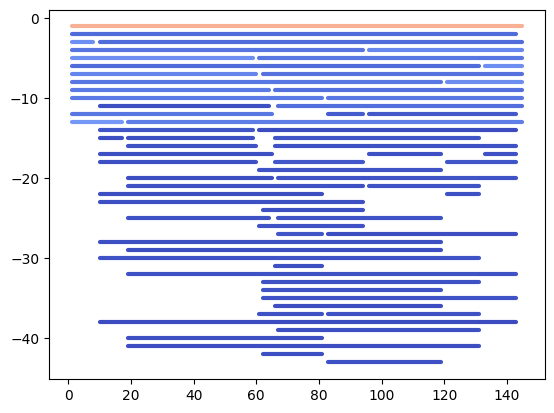

In [43]:
import matplotlib.pyplot as plt
import numpy as np


G = cleave(hbb, enzyme=protease_iv, n_cleaves=500)

def plot_peptigram(
    protein: str,
    G
    ):
    sequences = dict(G.nodes(data=True))
    fig, axs = plt.subplots(1, 1)
    spaces = np.zeros( (len(sequences.keys()), len(protein)))
    cmap = plt.get_cmap("coolwarm")
    for seq, c in sequences.items():
        #if len(seq) > 50:
        #   continue
        c = c["copy_number"]
        start = protein.find(seq)
        end = start + len(seq)
        for height in range(spaces.shape[0]):
            position = spaces[height, start:end]
            if sum(position) == 0:
                spaces[height, start : end + 1] = 1
                axs.plot(
                    [start + 1, end - 1],
                    [-height - 1, -height - 1],
                    linewidth=3,
                    c=cmap(c),
                    solid_capstyle="round")

                break

plot_peptigram(hbb, G)